Install and import required libraries

In [1]:
!pip install opendatasets -q
import opendatasets as od
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

DEPRECATION: Loading egg at c:\users\sadneya\appdata\local\programs\python\python312\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Libraries imported successfully!
TensorFlow version: 2.18.0


 Memory optimization

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

tf.keras.backend.clear_session()

 Load dataset

In [3]:
data = pd.read_csv("./full_df.csv")
print("Dataset shape:", data.shape)
data.head()

Dataset shape: (6392, 19)


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


Quick data preprocessing function

In [4]:
def has_condn(term, text):
    return 1 if term in str(text).lower() else 0

In [5]:
def create_balanced_dataset(data, samples_per_class=200):
    """Create balanced dataset with limited samples"""
    image_categories = {}
    
    # Normal
    normal_left = data.loc[(data.N == 1) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].values
    normal_right = data.loc[(data.N == 1) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].values
    image_categories['normal'] = np.concatenate([normal_left, normal_right])[:samples_per_class]
    
    # Cataract
    cataract_left = data.loc[(data.C == 1) & (data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract", x)) == 1)]["Left-Fundus"].values
    cataract_right = data.loc[(data.C == 1) & (data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract", x)) == 1)]["Right-Fundus"].values
    image_categories['cataract'] = np.concatenate([cataract_left, cataract_right])[:samples_per_class]
    
    # Diabetes
    diabetes_left = data.loc[(data.D == 1) & (data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy", x)) == 1)]["Left-Fundus"].values
    diabetes_right = data.loc[(data.D == 1) & (data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy", x)) == 1)]["Right-Fundus"].values
    image_categories['diabetes'] = np.concatenate([diabetes_left, diabetes_right])[:samples_per_class]
    
    # Glaucoma
    glaucoma_left = data.loc[(data.G == 1) & (data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma", x)) == 1)]["Left-Fundus"].values
    glaucoma_right = data.loc[(data.G == 1) & (data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma", x)) == 1)]["Right-Fundus"].values
    image_categories['glaucoma'] = np.concatenate([glaucoma_left, glaucoma_right])[:samples_per_class]
    
    # Hypertension
    hyper_left = data.loc[(data.H == 1) & (data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive", x)) == 1)]["Left-Fundus"].values
    hyper_right = data.loc[(data.H == 1) & (data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive", x)) == 1)]["Right-Fundus"].values
    image_categories['hypertension'] = np.concatenate([hyper_left, hyper_right])[:samples_per_class]
    
    # Myopia
    myopia_left = data.loc[(data.M == 1) & (data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia", x)) == 1)]["Left-Fundus"].values
    myopia_right = data.loc[(data.M == 1) & (data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia", x)) == 1)]["Right-Fundus"].values
    image_categories['myopia'] = np.concatenate([myopia_left, myopia_right])[:samples_per_class]
    
    # AMD
    amd_left = data.loc[(data.A == 1) & (data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration", x)) == 1)]["Left-Fundus"].values
    amd_right = data.loc[(data.A == 1) & (data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration", x)) == 1)]["Right-Fundus"].values
    image_categories['amd'] = np.concatenate([amd_left, amd_right])[:samples_per_class]
    
    # Other
    other_left = data.loc[(data.O == 1) & (data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen", x)) == 1)]["Left-Fundus"].values
    other_right = data.loc[(data.O == 1) & (data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen", x)) == 1)]["Right-Fundus"].values
    image_categories['other'] = np.concatenate([other_left, other_right])[:samples_per_class]
    
    return image_categories


Create balanced dataset

In [6]:
print("Creating balanced dataset...")
image_categories = create_balanced_dataset(data, samples_per_class=80)

Creating balanced dataset...


In [7]:
print("Dataset stats:")
for category, images in image_categories.items():
    print(f"{category}: {len(images)}")


Dataset stats:
normal: 80
cataract: 80
diabetes: 80
glaucoma: 80
hypertension: 80
myopia: 80
amd: 80
other: 80


Create directory structure for TensorFlow

In [8]:
import shutil

def create_simple_directory_structure(image_categories, base_dir="./simple_eye_dataset"):
    """Create simple directory structure"""
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir)
    
    # Create directories
    for category in image_categories.keys():
        os.makedirs(os.path.join(base_dir, 'train', category), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'val', category), exist_ok=True)
        os.makedirs(os.path.join(base_dir, 'test', category), exist_ok=True)
    
    # Copy images
    dataset_dir = "./preprocessed_images"
    
    for category, image_list in image_categories.items():
        if len(image_list) == 0:
            continue
            
        # Simple split: 70% train, 15% val, 15% test
        train_imgs = image_list[:int(0.7 * len(image_list))]
        val_imgs = image_list[int(0.7 * len(image_list)):int(0.85 * len(image_list))]
        test_imgs = image_list[int(0.85 * len(image_list)):]
        
        # Copy images
        for img_name in train_imgs:
            src = os.path.join(dataset_dir, img_name)
            dst = os.path.join(base_dir, 'train', category, img_name)
            if os.path.exists(src):
                shutil.copy2(src, dst)
        
        for img_name in val_imgs:
            src = os.path.join(dataset_dir, img_name)
            dst = os.path.join(base_dir, 'val', category, img_name)
            if os.path.exists(src):
                shutil.copy2(src, dst)
        
        for img_name in test_imgs:
            src = os.path.join(dataset_dir, img_name)
            dst = os.path.join(base_dir, 'test', category, img_name)
            if os.path.exists(src):
                shutil.copy2(src, dst)
    
    return base_dir

# Create directory structure
print("Creating directory structure...")
base_dir = create_simple_directory_structure(image_categories)
print("Directory structure created!")


Creating directory structure...
Directory structure created!


Create TensorFlow Data Generators

In [9]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

# Simple data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

# No augmentation for validation and test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Get class names
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")


Found 434 images belonging to 8 classes.
Found 96 images belonging to 8 classes.
Found 92 images belonging to 8 classes.
Training samples: 434
Validation samples: 96
Test samples: 92
Classes: ['amd', 'cataract', 'diabetes', 'glaucoma', 'hypertension', 'myopia', 'normal', 'other']


 Visualize sample images

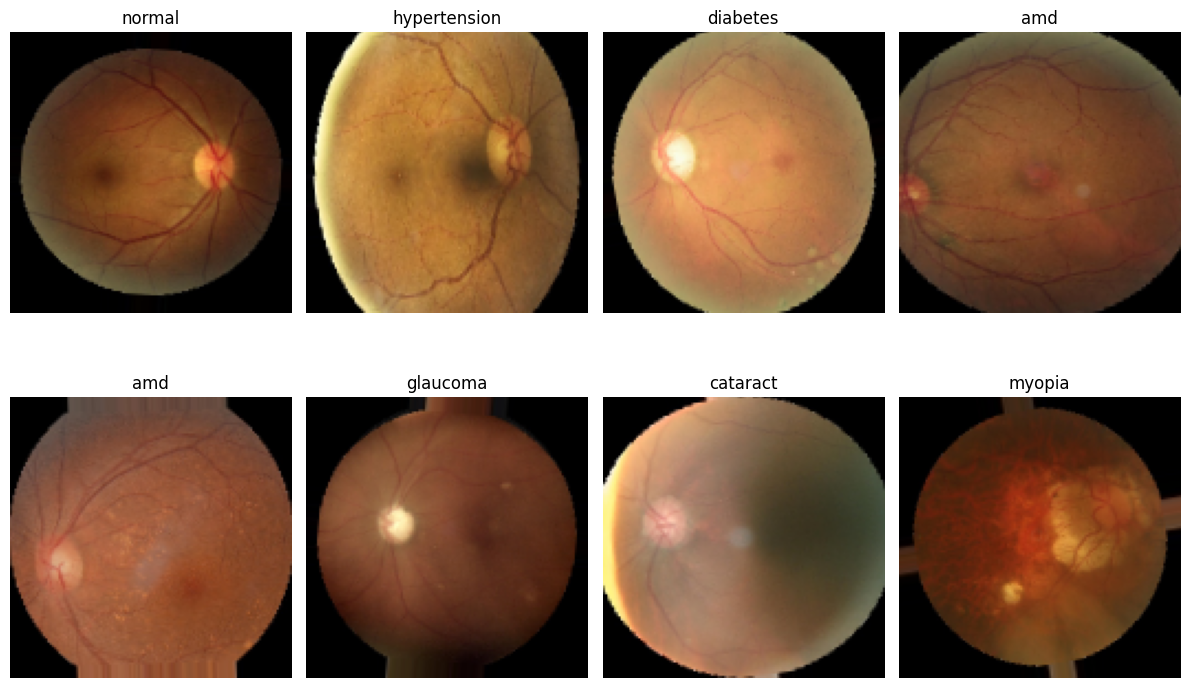

In [10]:
plt.figure(figsize=(12, 8))
batch = next(train_generator)
images, labels = batch

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    class_idx = np.argmax(labels[i])
    plt.title(f'{class_names[class_idx]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Ultra-simple VGG16 model

In [11]:
print("Creating ultra-simple VGG16 model...")

# Simple model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Creating ultra-simple VGG16 model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 66,696 (260.53 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Simple callbacks

In [12]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_simple_vgg16.keras', save_best_only=True, monitor='val_accuracy')
]

Train the model

In [13]:
print("Training simple model...")
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)
print("Simple model training completed!")

Training simple model...
Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 660ms/step - accuracy: 0.1125 - loss: 2.3228 - val_accuracy: 0.1771 - val_loss: 2.0681
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 735ms/step - accuracy: 0.1449 - loss: 2.1021 - val_accuracy: 0.2292 - val_loss: 2.0333
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 832ms/step - accuracy: 0.1591 - loss: 2.0761 - val_accuracy: 0.1875 - val_loss: 2.0202
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 766ms/step - accuracy: 0.2208 - loss: 1.9983 - val_accuracy: 0.2604 - val_loss: 1.9961
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 789ms/step - accuracy: 0.2348 - loss: 1.9768 - val_accuracy: 0.2708 - val_loss: 1.9742
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 821ms/step - accuracy: 0.2429 - loss: 1.9657 - val_accuracy: 0.1979 - val_loss: 1.9672
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 848ms/step - accuracy: 0.2973 - loss: 1.9423 - val_accuracy: 0.2917 - val_loss: 1.9302
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 836ms/step - accuracy: 0.3014 

Evaluate model

In [14]:
print("Evaluating model...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Evaluating model...
Test Accuracy: 0.4130
Test Loss: 1.5477


Plot training history

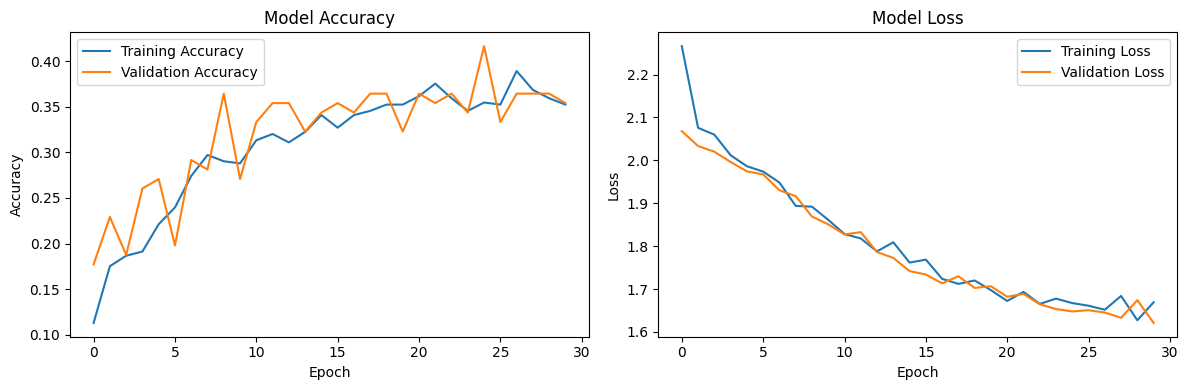

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Predictions and classification report

In [16]:
print("Making predictions...")
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Making predictions...
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 683ms/step
Classification Report:
              precision    recall  f1-score   support

         amd       0.38      0.25      0.30        12
    cataract       0.42      0.92      0.58        12
    diabetes       0.25      0.20      0.22        10
    glaucoma       0.31      0.33      0.32        12
hypertension       0.20      0.17      0.18        12
      myopia       0.92      1.00      0.96        12
      normal       0.00      0.00      0.00        12
       other       0.29      0.40      0.33        10

    accuracy                           0.41        92
   macro avg       0.35      0.41      0.36        92
weighted avg       0.35      0.41      0.37        92



Simple confusion matrix

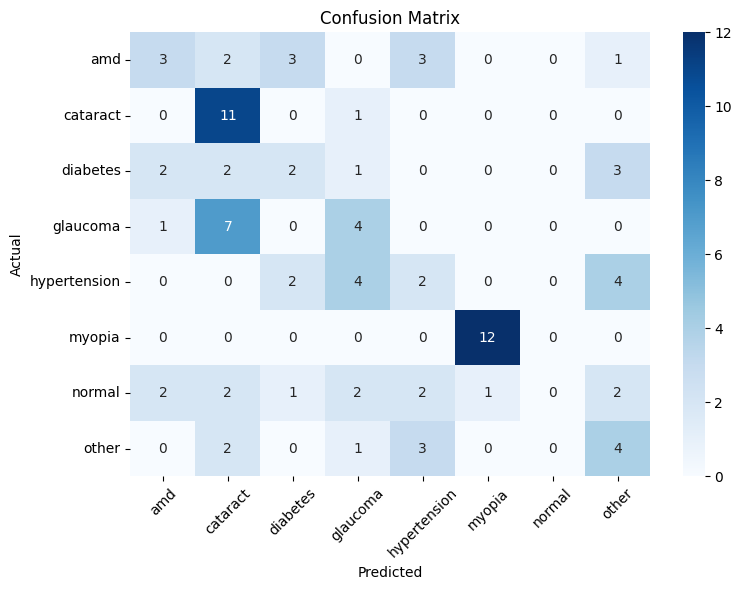

In [17]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Save model

In [18]:
model.save('simple_vgg16_eye_disease.keras')
print("Model saved successfully!")

Model saved successfully!


Simple prediction function

In [19]:
def simple_predict(image_path, model, class_names):
    """Simple prediction function"""
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    
    return predicted_class, confidence

Test predictions

In [20]:
print("\nTesting predictions...")
dataset_dir = "./preprocessed_images"

# Get some random test images
test_images = []
for category, image_list in image_categories.items():
    if len(image_list) > 0:
        test_images.append((random.choice(image_list), category))

print("Sample Predictions:")
for i, (img_name, true_class) in enumerate(test_images[:3]):
    img_path = os.path.join(dataset_dir, img_name)
    if os.path.exists(img_path):
        predicted_class, confidence = simple_predict(img_path, model, class_names)
        print(f"Image {i+1}: {img_name}")
        print(f"True: {true_class}")
        print(f"Predicted: {predicted_class} (Confidence: {confidence:.4f})")
        print("-" * 40)

print("\n" + "="*50)
print("ULTRA-SIMPLE VGG16 TRAINING COMPLETED!")
print("="*50)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Model: VGG16 + Simple Classifier")
print(f"Image Size: 128x128")
print(f"Training Samples: {train_generator.samples}")
print("="*50)


Testing predictions...
Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Image 1: 2356_left.jpg
True: normal
Predicted: myopia (Confidence: 0.2181)
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Image 2: 2144_left.jpg
True: cataract
Predicted: cataract (Confidence: 0.6517)
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Image 3: 288_left.jpg
True: diabetes
Predicted: cataract (Confidence: 0.4541)
----------------------------------------

ULTRA-SIMPLE VGG16 TRAINING COMPLETED!
Test Accuracy: 0.4130
Model: VGG16 + Simple Classifier
Image Size: 128x128
Training Samples: 434
